visualize the brains

TODO
* train factor analysis on GPU for a 2d slice (probably set $k=6$ for now).

## Imports and first visualization

In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns

import jax.numpy as jnp
import jax.random as jr

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

from cfos import seminmf_v3 as seminmf

In [3]:
DATA_DIREC = "/Users/xaviergonzalez/Desktop/xavier_folders/stanford/linderman/serotonin/data"

In [26]:
avg_logs = np.load(os.path.join(DATA_DIREC, "avg_logs.npy"))
counts = np.load(os.path.join(DATA_DIREC, "counts.npy"))
mouse_ids = np.load(os.path.join(DATA_DIREC, "mouse_ids.npy"))
alive_voxels = np.load(os.path.join(DATA_DIREC, "alive_voxels.npy"))
NUM_MICE = len(mouse_ids)
DIMS = np.load(os.path.join(DATA_DIREC, "dims.npy"))
DIMS = tuple(DIMS)

In [5]:
print(np.sum(alive_voxels))

384008


In [6]:
brains = np.zeros((NUM_MICE, np.prod(DIMS)))

In [7]:
brains[:, np.where(alive_voxels)[0]] = avg_logs

In [8]:
brains.shape

(168, 676400)

In [9]:
full_brains = brains.reshape((168, 89, 95, 80))

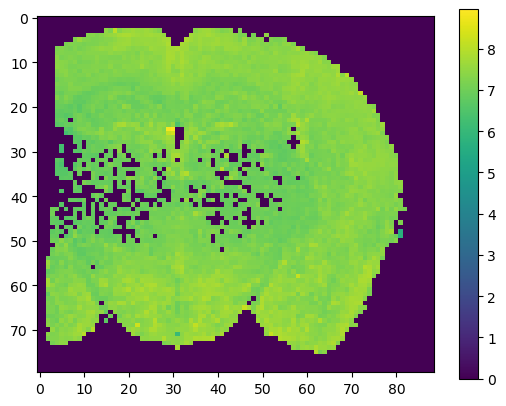

In [10]:
plt.imshow(full_brains[50, :, 50, :].T)
plt.colorbar()

## Fit the model!

In [41]:
data = avg_logs
num_factors = 6
loading_scale = 1 # hopefully this loading scale doesn't matter?

In [46]:
# Fit the model
losses, loadings, weights, emission_noise_var = \
    seminmf.fit_batch(data, 
                      counts,
                      num_factors,
                      loading_scale=loading_scale,
                      num_iters=15,
                      initialization="nnsvd",
                      # initialization="prior",
                      # key=0,
                      stepsize=1e-1,
                      dpp_prior_scale=data.size,
                      verbosity=1,
                      )

Imputing missing data based on a rank 20 SVD


  0%|                                                    | 0/15 [00:00<?, ?it/s]

Updating loadings
Updating factors
Updating emission noise variance


loss: -0.3656:   7%|█▉                           | 1/15 [00:06<01:24,  6.02s/it]

Updating loadings
Updating factors
Updating emission noise variance


loss: -0.3908:  13%|███▊                         | 2/15 [00:11<01:17,  5.98s/it]

Updating loadings
Updating factors
Updating emission noise variance


loss: -0.3915:  20%|█████▊                       | 3/15 [00:17<01:11,  5.93s/it]

Updating loadings
Updating factors
Updating emission noise variance


loss: -0.3916:  27%|███████▋                     | 4/15 [00:23<01:05,  5.92s/it]

Updating loadings
Updating factors
Updating emission noise variance


loss: -0.3917:  33%|█████████▋                   | 5/15 [00:29<00:59,  5.98s/it]

Updating loadings
Updating factors
Updating emission noise variance


loss: -0.3917:  40%|███████████▌                 | 6/15 [00:35<00:53,  5.95s/it]

Updating loadings
Updating factors
Updating emission noise variance


loss: -0.3917:  47%|█████████████▌               | 7/15 [00:41<00:47,  5.97s/it]

Updating loadings
Updating factors
Updating emission noise variance


loss: -0.3918:  53%|███████████████▍             | 8/15 [00:47<00:42,  6.00s/it]

Updating loadings
Updating factors
Updating emission noise variance


loss: -0.3918:  60%|█████████████████▍           | 9/15 [00:53<00:35,  5.99s/it]

Updating loadings
Updating factors
Updating emission noise variance


loss: -0.3918:  67%|██████████████████▋         | 10/15 [00:59<00:29,  5.96s/it]

Updating loadings
Updating factors
Updating emission noise variance


loss: -0.3918:  73%|████████████████████▌       | 11/15 [01:05<00:23,  5.99s/it]

Updating loadings
Updating factors
Updating emission noise variance


loss: -0.3916:  80%|██████████████████████▍     | 12/15 [01:11<00:18,  6.05s/it]

Updating loadings
Updating factors
Updating emission noise variance


loss: -0.3918:  87%|████████████████████████▎   | 13/15 [01:17<00:12,  6.03s/it]

Updating loadings
Updating factors
Updating emission noise variance


loss: -0.3919:  93%|██████████████████████████▏ | 14/15 [01:23<00:06,  6.00s/it]

Updating loadings
Updating factors
Updating emission noise variance


loss: -0.3919: 100%|████████████████████████████| 15/15 [01:29<00:00,  5.98s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


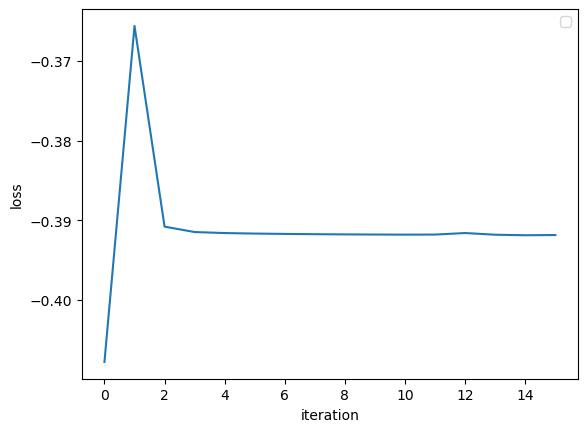

In [47]:
# Plot the losses
plt.figure()
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()

In [48]:
def make_full(H, dims, alive_voxels, order='C'):
    """
    dims: tuple
    """
    if len(np.shape(H))==1:
        k = 1
    else:
        k = H.shape[0]
    num_voxels = np.prod(dims)
    brain = np.zeros((k, num_voxels))
    brain[:, alive_voxels] = H
    if k==1:
        brain = np.reshape(brain, dims, order=order)
    else:
        brain = np.reshape(brain, (k,) + dims, order=order)
    return(brain)
def _largest_factor(n):
    start = int(np.floor(np.sqrt(n)))
    while n % start != 0:
        start -= 1
    return(int(start))
def plot_all_factors(H, dims, alive_voxels, order='C', y=0, figsize=10):
    factors = make_full(H, dims, alive_voxels, order=order)
    K = np.shape(factors)[0]
    l = _largest_factor(K)
    m = int(K / l)
    fig, ax = plt.subplots(l,m, figsize=(figsize,figsize))
    for i in range(K):
        idx_first = i%l
        idx_second = int(np.floor(i / l))
        current_factor = factors[i]
        current_factor = current_factor / np.max(np.abs(current_factor))

        ax[idx_first,idx_second] = sns.heatmap(current_factor[:, y, :].T, 
                        cmap="RdBu_r", vmin=-1, vmax=1, ax=ax[idx_first,idx_second], 
                        cbar=False, xticklabels=False, yticklabels=False)
    plt.show()

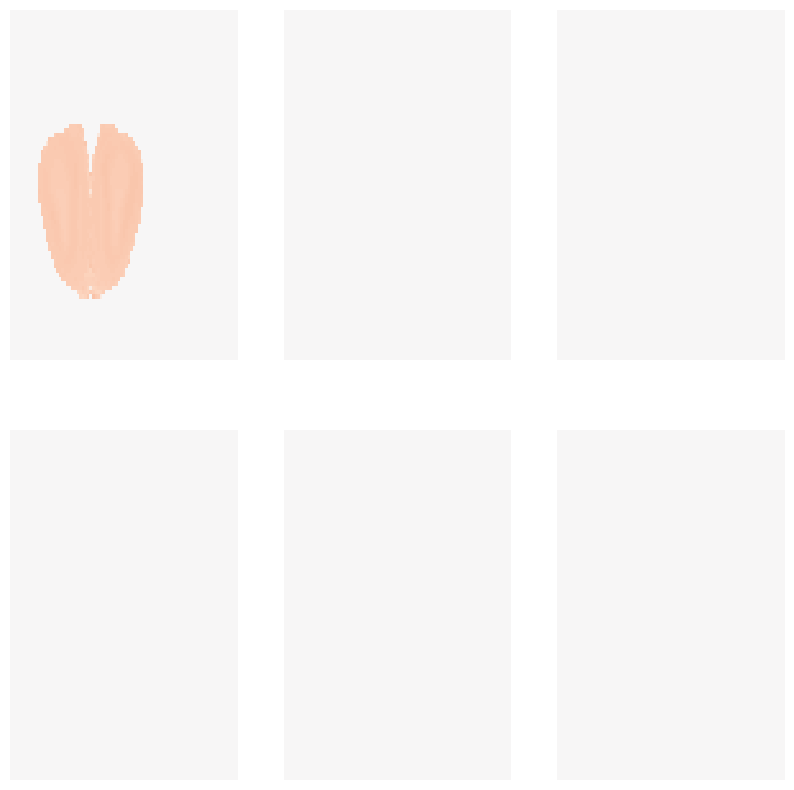

In [49]:
plot_all_factors(weights, DIMS, alive_voxels)